In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import numpy as np
import random 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl

In [71]:
mpl.rcParams['figure.dpi']= 150
plt.rcdefaults()

In [107]:
import rmab.secret as secret 
from rmab.database import open_connection, close_connection, run_query
from rmab.fr_dynamics import get_transitions, get_all_transitions
from rmab.plots import plot_transition_dynamics

In [5]:
db_name = secret.database_name 
username = secret.database_username 
password = secret.database_password 
ip_address = secret.ip_address
port = secret.database_port

In [6]:
connection_dict = open_connection(db_name,username,password,ip_address,port)
connection = connection_dict['connection']
cursor = connection_dict['cursor']

In [7]:
sample_query = run_query(cursor,"SELECT * FROM RESCUES LIMIT 1")

In [8]:
sample_query[0]

{'id': 4,
 'donation_id': 4,
 'recipient_location_id': 50,
 'published_at': datetime.datetime(2018, 3, 5, 14, 4),
 'created_at': datetime.datetime(2018, 3, 5, 14, 7, 1, 559052),
 'updated_at': datetime.datetime(2018, 3, 5, 15, 57, 5, 537438),
 'state': 8,
 'user_id': 352,
 'rescue_group_id': None,
 'distance': Decimal('2.6'),
 'admin_id': 2150,
 'recipient_name': 'Tausha',
 'recipient_signature_image_file_name': 'recipient_signature_imagepng',
 'recipient_signature_image_content_type': 'image/png',
 'recipient_signature_image_file_size': 9436,
 'recipient_signature_image_updated_at': datetime.datetime(2018, 3, 5, 15, 55, 14, 81569),
 'volunteer_rating': 3,
 'volunteer_comment': 'Wilkinsburg family center on fifth floor. Contact phone number would be nice, so we can call before we get there.',
 'volunteer_social_image_file_name': None,
 'volunteer_social_image_content_type': None,
 'volunteer_social_image_file_size': None,
 'volunteer_social_image_updated_at': None,
 'donor_contact_name

## Volunteer Analysis

In [9]:
query = ("SELECT user_id, COUNT(*) AS frequency " 
 "FROM RESCUES " 
 "WHERE PUBLISHED_AT <= CURRENT_DATE "
 "AND USER_ID IS NOT NULL "
 "GROUP BY user_id "
 "ORDER BY frequency DESC ")

In [10]:
volunteer_frequencies = run_query(cursor,query)
user_frequencies = [i['frequency'] for i in volunteer_frequencies]

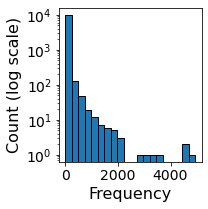

In [11]:
plt.figure(figsize=(3,3))
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Count (log scale)',fontsize=16)
plt.hist(user_frequencies, bins=20, log=True, edgecolor='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout() 

In [12]:
np.mean(user_frequencies), np.std(user_frequencies)

(33.57634450889785, 151.18199503154307)

In [13]:
query = ("SELECT user_id, "
"MAX(published_at) - MIN(published_at) AS time_difference " 
"FROM RESCUES "
"WHERE PUBLISHED_AT <= CURRENT_DATE "
"AND USER_ID IS NOT NULL "
"GROUP BY user_id"
)

In [14]:
time_served_by_user = run_query(cursor,query)
time_served_by_user = [i['time_difference'].days for i in time_served_by_user]

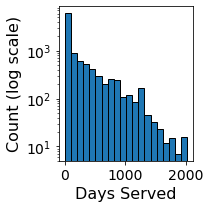

In [15]:
plt.figure(figsize=(3,3))
plt.xlabel('Days Served',fontsize=16)
plt.ylabel('Count (log scale)',fontsize=16)
plt.hist(time_served_by_user, bins=20, log=True, edgecolor='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout() 

In [16]:
query = (
    "SELECT USER_ID, PUBLISHED_AT "
    "FROM RESCUES "
    "WHERE PUBLISHED_AT <= CURRENT_DATE "
    "AND USER_ID IS NOT NULL "
)

In [17]:
all_user_published = run_query(cursor,query)

data_by_user = {}
for i in all_user_published:
    user_id = i['user_id']
    published_at = i['published_at']

    if user_id not in data_by_user:
        data_by_user[user_id] = []

    data_by_user[user_id].append(published_at)

for i in data_by_user:
    data_by_user[i] = sorted(data_by_user[i])

In [18]:
differences_between = []

for i in range(100):
    num_with = 0
    total_diff = 0

    for j in data_by_user:
        if len(data_by_user[j])>=i+2:
            num_with += 1

            total_diff += (data_by_user[j][i+1]-data_by_user[j][i]).days  

    total_diff /= (num_with)
    differences_between.append(total_diff)

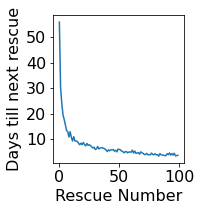

In [19]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between)

In [20]:
rescues_by_user = [len(data_by_user[i]) for i in data_by_user]
num_users_at_least = []

for i in range(100):
    users_with_i_rescues = [1 for r in rescues_by_user if r>=i]
    num_users_at_least.append(len(users_with_i_rescues))

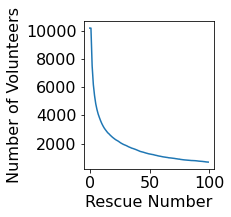

In [21]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number", fontsize=16)
plt.ylabel("Number of Volunteers",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(num_users_at_least)

In [22]:
# Fix the number of total rescues at 20; how does time difference then change 
differences_between = []

for i in range(19):
    num_with = 0
    total_diff = 0

    for j in data_by_user:
        if len(data_by_user[j])>=i+2 and len(data_by_user[j]) == 20:
            num_with += 1

            total_diff += (data_by_user[j][i+1]-data_by_user[j][i]).days  

    total_diff /= (num_with)
    differences_between.append(total_diff)

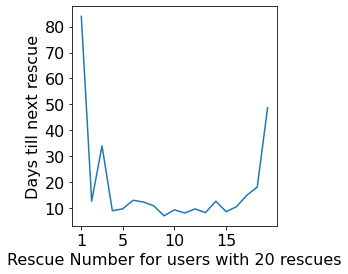

In [23]:
plt.figure(figsize=(4,4))
plt.xlabel("Rescue Number for users with 20 rescues", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([0,4,9,14,19],[1,5,10,15,20],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between)

In [24]:
# Fix the number of total rescues at 20; how does time difference then change 
differences_between = []

for i in range(4):
    num_with = 0
    total_diff = 0

    for j in data_by_user:
        if len(data_by_user[j])>=i+2 and len(data_by_user[j]) == 5:
            num_with += 1

            total_diff += (data_by_user[j][i+1]-data_by_user[j][i]).days  

    total_diff /= (num_with)
    differences_between.append(total_diff)

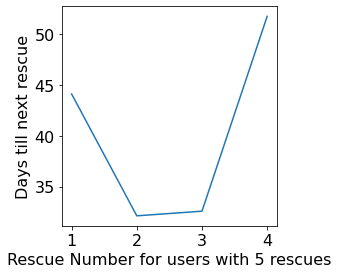

In [25]:
plt.figure(figsize=(4,4))
plt.xlabel("Rescue Number for users with 5 rescues", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks(list(range(0,5)),list(range(1,6)),fontsize=16)
plt.yticks([35,40,45,50],fontsize=16)
plt.tight_layout()
plt.plot(differences_between)

In [26]:
# Fix the number of total rescues at 10; how does time difference then change 
differences_between = []

for i in range(9):
    num_with = 0
    total_diff = 0

    for j in data_by_user:
        if len(data_by_user[j])>=i+2 and len(data_by_user[j]) == 10:
            num_with += 1

            total_diff += (data_by_user[j][i+1]-data_by_user[j][i]).days  

    total_diff /= (num_with)
    differences_between.append(total_diff)

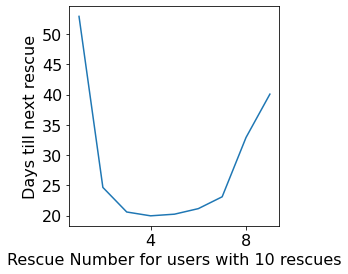

In [27]:
plt.figure(figsize=(4,4))
plt.xlabel("Rescue Number for users with 10 rescues", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([3,7],[4,8],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between)

In [28]:
# Fix the number of total rescues at 20; how does time difference then change 
differences_between = []

for i in range(49):
    num_with = 0
    total_diff = 0

    for j in data_by_user:
        if len(data_by_user[j])>=i+2 and len(data_by_user[j]) == 50:
            num_with += 1

            total_diff += (data_by_user[j][i+1]-data_by_user[j][i]).days  

    total_diff /= (num_with)
    differences_between.append(total_diff)

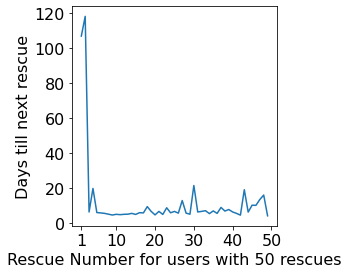

In [29]:
plt.figure(figsize=(4,4))
plt.xlabel("Rescue Number for users with 50 rescues", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([0,9,19,29,39,49],[1,10,20,30,40,50],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between)

## Transition Dynamics

In [49]:
all_transitions = {}

for i in range(2,101):
    all_transitions[i] = get_transitions(data_by_user,i)

In [58]:
all_transitions[2][0][1]

array([1., 0.])

Text(0.5, 1.0, 'Volunteers with 2 rescues')

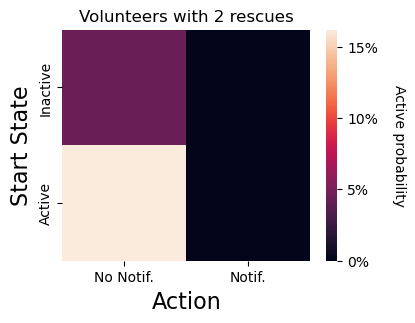

In [82]:
num_rescues = 2
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0,0.05,0.1,0.15])
cbar.set_ticklabels(['0%','5%','10%','15%'])
plt.title("Volunteers with {} rescues".format(num_rescues))

Text(0.5, 1.0, 'Volunteers with 10 rescues')

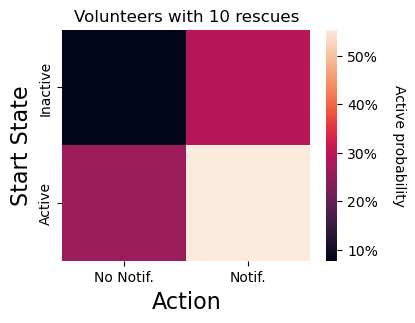

In [85]:
num_rescues = 10
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0.1,0.2,0.3,0.4,0.5])
cbar.set_ticklabels(['10%','20%','30%','40%','50%'])
plt.title("Volunteers with {} rescues".format(num_rescues))

Text(0.5, 1.0, 'Volunteers with 50 rescues')

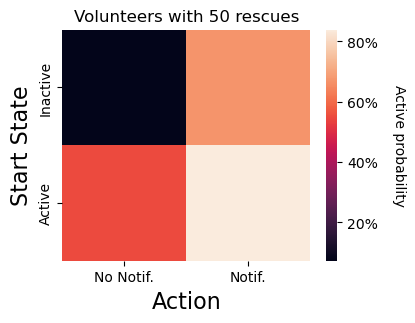

In [88]:
num_rescues = 50
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0.2,0.4,0.6,0.8])
cbar.set_ticklabels(['20%','40%','60%','80%'])
plt.title("Volunteers with {} rescues".format(num_rescues))

In [102]:
chance_notification_works_inactive = [all_transitions[i][0][1][1] for i in all_transitions]
chance_notification_works_active = [all_transitions[i][1][1][1] for i in all_transitions]

Text(0.5, 1.0, 'Impact of Volunteer state, experience on notif. success')

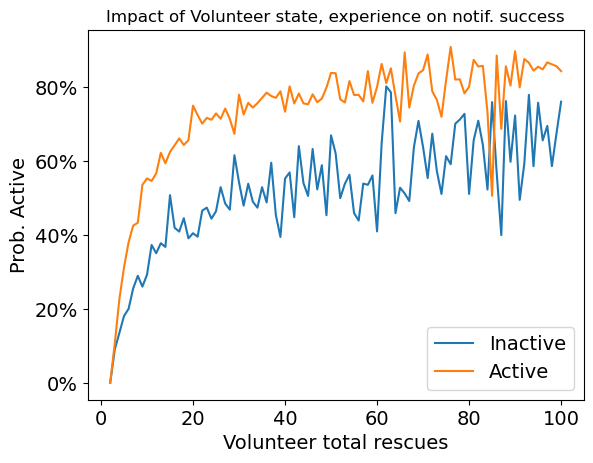

In [103]:
plt.plot(list(range(2,2+len(chance_notification_works_inactive))),chance_notification_works_inactive,label='Inactive')
plt.plot(list(range(2,2+len(chance_notification_works_active))),chance_notification_works_active,label='Active')
plt.xlabel('Volunteer total rescues',fontsize=14)
plt.ylabel('Prob. Active',fontsize=14)
plt.yticks([0.0,0.2,0.4,0.6,0.8],['0%','20%','40%','60%','80%'],fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.title("Impact of Volunteer state, experience on notif. success")

In [104]:
chance_silence_works_inactive = [all_transitions[i][0][0][1] for i in all_transitions]
chance_silence_works_active = [all_transitions[i][1][0][1] for i in all_transitions]

Text(0.5, 1.0, 'Impact of Volunteer state, experience on silence success')

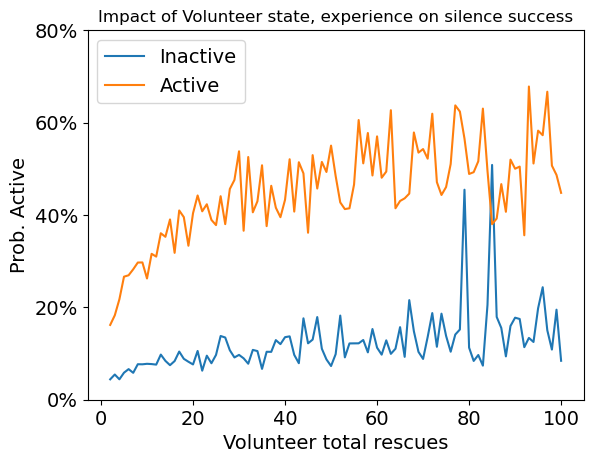

In [106]:
plt.plot(list(range(2,2+len(chance_silence_works_inactive))),chance_silence_works_inactive,label='Inactive')
plt.plot(list(range(2,2+len(chance_silence_works_active))),chance_silence_works_active,label='Active')
plt.xlabel('Volunteer total rescues',fontsize=14)
plt.ylabel('Prob. Active',fontsize=14)
plt.yticks([0.0,0.2,0.4,0.6,0.8],['0%','20%','40%','60%','80%'],fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.title("Impact of Volunteer state, experience on silence success")